# 🏘️ Melbourne Housing Price Prediction

This notebook presents a complete **applied machine learning workflow** using the **Melbourne Housing Snapshot** dataset from Kaggle. The goal is to build a robust model to predict house prices from structured tabular features, while following modern best practices: reproducible pipelines, proper validation, and model interpretability.

We will:
- Load and explore the dataset
- Separate features and target
- Build preprocessing pipelines for numeric and categorical data
- Train a gradient boosting regression model
- Evaluate performance using Mean Absolute Error (MAE)
- Interpret results with permutation feature importance

---

## 📐 Modeling and Evaluation Notes

**Target transformation.** House prices are often right-skewed. We therefore model
the logarithm of price:

$$
y = \log(\text{Price})
$$

Predictions are transformed back via:

$$
\hat{\text{Price}} = \exp(\hat{y})
$$

**Evaluation metric.** We use Mean Absolute Error (MAE):

$$
\text{MAE} = \frac{1}{N} \sum_{i=1}^N \left| y_i - \hat{y}_i \right|
$$

MAE is easy to interpret here because it is expressed directly in currency units.

---

### ▶️ Analysis step

This cell performs an intermediate step in the applied ML workflow.

In [1]:
import kaggle
import os, zipfile
import pandas as pd

kaggle.api.authenticate()

dataset = "dansbecker/melbourne-housing-snapshot"
download_path = "data_melb"

os.makedirs(download_path, exist_ok=True)

kaggle.api.dataset_download_files(dataset, path=download_path)

zip_path = os.path.join(download_path, "melbourne-housing-snapshot.zip")
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(download_path)

print("Done. Files:", os.listdir(download_path))


Dataset URL: https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot
Done. Files: ['melb_data.csv', 'melbourne-housing-snapshot.zip']


### 📥 Load the Melbourne Housing dataset

This cell loads the Kaggle dataset into a pandas DataFrame for analysis.

In [2]:
# save filepath to variable for easier access
melbourne_file_path = 'data_melb/melb_data.csv'
# read the data and store data in DataFrame titled melbourne_data
melbourne_data = pd.read_csv(melbourne_file_path)
# print a summary of the data in Melbourne data
melbourne_data.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13518.000000,13580.000000,7130.000000,8205.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,3105.301915,2.914728,1.534242,1.610075,558.416127,151.967650,1964.684217,-37.809203,144.995216,7454.417378
std,0.955748,6.393107e+05,5.868725,90.676964,0.965921,0.691712,0.962634,3990.669241,541.014538,37.273762,0.079260,0.103916,4378.581772
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810,249.000000
25%,2.000000,6.500000e+05,6.100000,3044.000000,2.000000,1.000000,1.000000,177.000000,93.000000,1940.000000,-37.856822,144.929600,4380.000000
50%,3.000000,9.030000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.802355,145.000100,6555.000000
75%,3.000000,1.330000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,651.000000,174.000000,1999.000000,-37.756400,145.058305,10331.000000
max,10.000000,9.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


### 🔍 Explore the dataset

Here we inspect the structure and basic statistics of the data to understand available features and missing values.

In [3]:
melbourne_data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


### 🔍 Explore the dataset

Here we inspect the structure and basic statistics of the data to understand available features and missing values.

In [4]:
# Let's build a model

y = melbourne_data.Price
features = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 'YearBuilt']
X = melbourne_data[features]
X.head()

,Rooms,Bathroom,Landsize,BuildingArea,YearBuilt
0,2,1.0,202.0,NaN,NaN
1,2,1.0,156.0,79.0,1900.0
2,3,2.0,134.0,150.0,1900.0
3,3,2.0,94.0,NaN,NaN
4,4,1.0,120.0,142.0,2014.0


### ▶️ Analysis step

This cell performs an intermediate step in the applied ML workflow.

In [5]:
X.isnull().sum()

Rooms              0
Bathroom           0
Landsize           0
BuildingArea    6450
YearBuilt       5375
dtype: int64

### ▶️ Analysis step

This cell performs an intermediate step in the applied ML workflow.

In [6]:
X = X.dropna()
y = y.loc[X.index]

### 🔀 Train / validation split

Split the dataset into training and validation sets to evaluate model performance on unseen data.

In [7]:
# Train the model
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### 📏 Evaluate performance

Generate predictions on the validation set and compute the Mean Absolute Error (MAE).

In [8]:
from sklearn.metrics import mean_absolute_error

preds = model.predict(X_valid)
mae = mean_absolute_error(y_valid, preds)

mae

288664.6542500511

### 📏 Evaluate performance

Generate predictions on the validation set and compute the Mean Absolute Error (MAE).

In [9]:
comparison = pd.DataFrame({
    'Actual': y_valid[:10],
    'Predicted': preds[:10]
})
comparison

,Actual,Predicted
863,1035000.0,1.219710e+06
5473,945000.0,8.773600e+05
3903,650000.0,8.068550e+05
8507,2075000.0,1.471495e+06
9424,616000.0,5.617517e+05
11389,1150000.0,1.476055e+06
5310,990000.0,9.666300e+05
4051,1055000.0,1.498440e+06
2501,1730000.0,8.108608e+05
5951,425000.0,6.246650e+05


### ▶️ Analysis step

This cell performs an intermediate step in the applied ML workflow.

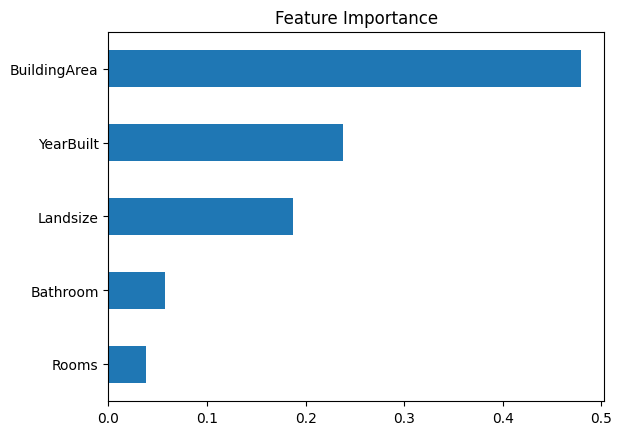

In [10]:
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()

### 📥 Load the Melbourne Housing dataset

This cell loads the Kaggle dataset into a pandas DataFrame for analysis.

In [12]:
# okay, let's start over and do it properly with missing values handled upfront

from sklearn.model_selection import train_test_split
data = pd.read_csv("data_melb/melb_data.csv")

y = data["Price"]
X = data.drop(columns=["Price"])

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧹 Preprocessing pipeline

Define preprocessing steps for numeric and categorical features, including missing-value imputation and one-hot encoding.

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Separate column types
categorical_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
numeric_cols = [c for c in X_train.columns if X_train[c].dtype != "object"]

# Preprocessing for numeric data
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Bundle preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

### 🏋️ Train the model

Fit the preprocessing pipeline and model on the training data.

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

clf.fit(X_train, y_train)

preds = clf.predict(X_valid)
mae = mean_absolute_error(y_valid, preds)
mae

161879.68379725085

### 🤖 Define the model

Initialize a histogram-based gradient boosting regressor for tabular regression.

In [14]:
from sklearn.ensemble import HistGradientBoostingRegressor

gbr = HistGradientBoostingRegressor(
    random_state=42
)

clf_gbr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", gbr)
])

clf_gbr.fit(X_train, y_train)
preds_gbr = clf_gbr.predict(X_valid)
mae_gbr = mean_absolute_error(y_valid, preds_gbr)
mae_gbr

159664.66734189182

### 📏 Evaluate performance

Generate predictions on the validation set and compute the Mean Absolute Error (MAE).

In [15]:
import numpy as np

preview = X_valid.copy()
preview["Actual"] = y_valid
preview["Predicted"] = preds_gbr
preview[["Actual", "Predicted"]].head(10)

,Actual,Predicted
1061,2600000.0,2.283333e+06
6482,620000.0,6.873115e+05
8395,1000000.0,8.345285e+05
4659,430000.0,5.620186e+05
7386,392250.0,7.848563e+05
6607,700000.0,7.806528e+05
8094,439000.0,5.137100e+05
4590,2236000.0,1.903474e+06
13475,671000.0,5.472798e+05
10318,1870000.0,1.466796e+06


### 📏 Evaluate performance

Generate predictions on the validation set and compute the Mean Absolute Error (MAE).

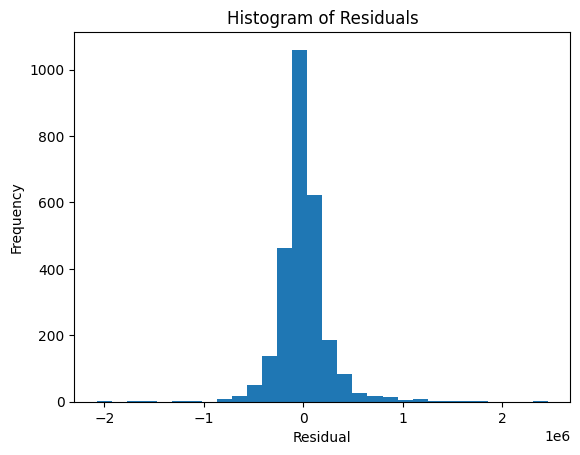

In [16]:
# Calculate the residuals
preview["Residual"] = preview["Actual"] - preview["Predicted"]
# plot a histogram of the residuals
plt.hist(preview["Residual"], bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

### 📏 Evaluate performance

Generate predictions on the validation set and compute the Mean Absolute Error (MAE).

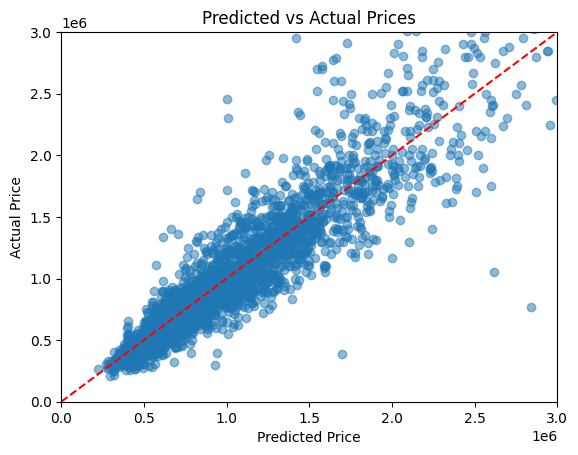

In [17]:
# create a plot of predicted vs actual values
plt.scatter(preview["Predicted"], preview["Actual"], alpha=0.5)
plt.plot([0, 3000000], [0, 3000000], color='red', linestyle='--')
plt.title("Predicted vs Actual Prices")
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.xlim(0, 3000000)
plt.ylim(0, 3000000)
plt.show()

### ▶️ Analysis step

This cell performs an intermediate step in the applied ML workflow.

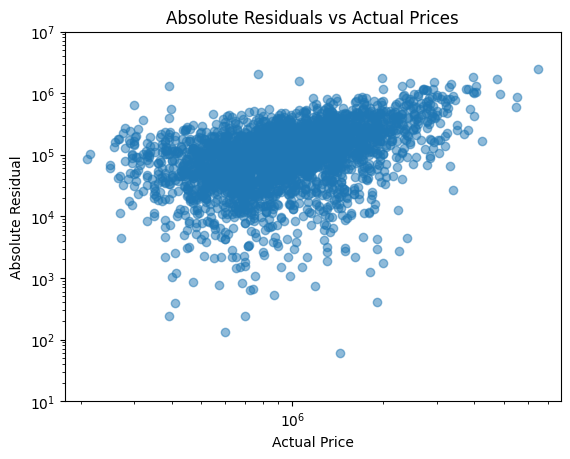

In [18]:
# create a plot of abs(residuals) vs actual values
plt.scatter(preview["Actual"], np.abs(preview["Residual"]), alpha=0.5)
plt.title("Absolute Residuals vs Actual Prices")
plt.xlabel("Actual Price")
plt.ylabel("Absolute Residual")
# make x axis log scale
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e1, 1E7)
plt.show()

### ▶️ Analysis step

This cell performs an intermediate step in the applied ML workflow.

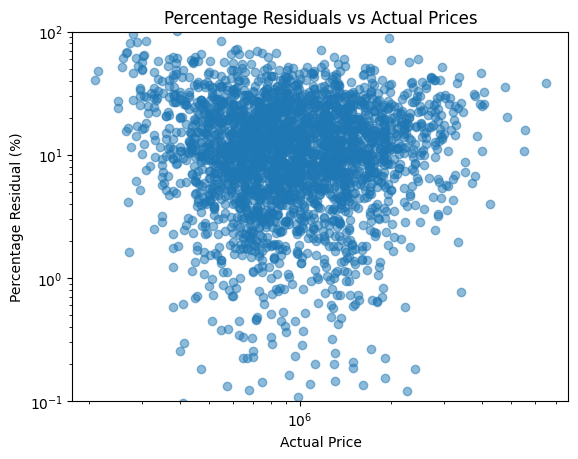

In [19]:
# create residuals as a percentage of actual price
preview["ResidualPercent"] = np.abs(preview["Residual"]) / preview["Actual"] * 100
# plot a graph of percent residuals vs actual values
plt.scatter(preview["Actual"], preview["ResidualPercent"], alpha=0.5)
plt.title("Percentage Residuals vs Actual Prices")
plt.xlabel("Actual Price")
plt.ylabel("Percentage Residual (%)")
# make x axis log scale
plt.xscale("log")
plt.yscale("log")
plt.ylim(0.1, 100)
plt.show()

### ▶️ Analysis step

This cell performs an intermediate step in the applied ML workflow.

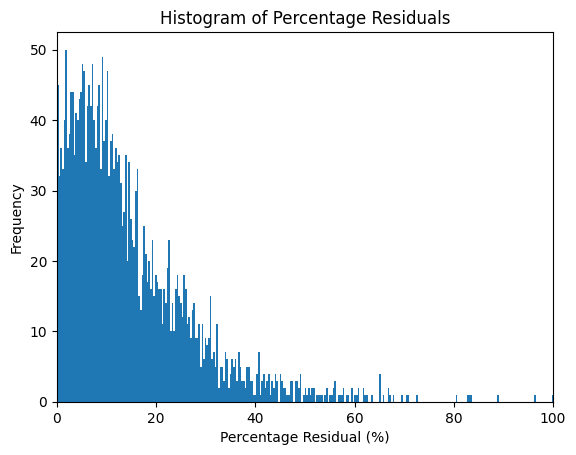

In [20]:
# and now plot a histogram of the percentage residuals
plt.hist(preview["ResidualPercent"], bins=1000)
plt.title("Histogram of Percentage Residuals")
plt.xlabel("Percentage Residual (%)")
plt.ylabel("Frequency")
plt.xlim(0, 100)
plt.show()

### 🔀 Train / validation split

Split the dataset into training and validation sets to evaluate model performance on unseen data.

In [21]:
import numpy as np

y_log = np.log(y)

X_train, X_valid, y_train_log, y_valid_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

clf_gbr.fit(X_train, y_train_log)

preds_log = clf_gbr.predict(X_valid)

# back-transform
preds = np.exp(preds_log)
y_valid_orig = np.exp(y_valid_log)

mae_log = mean_absolute_error(y_valid_orig, preds)
mae_log

153940.09764860212

### 🤖 Define the model

Initialize a histogram-based gradient boosting regressor for tabular regression.

In [22]:
gbr_tuned = HistGradientBoostingRegressor(
    max_depth=8,
    learning_rate=0.05,
    max_iter=300,
    random_state=42
)

clf_gbr_tuned = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", gbr_tuned)
])

clf_gbr_tuned.fit(X_train, y_train_log)
preds_log = clf_gbr_tuned.predict(X_valid)

preds = np.exp(preds_log)
mae_tuned = mean_absolute_error(y_valid_orig, preds)
mae_tuned

152526.6192914828

### 🧠 Feature importance

Estimate permutation importance to understand which input features most influence predictions.

In [23]:
from sklearn.inspection import permutation_importance
import pandas as pd

result = permutation_importance(
    clf_gbr_tuned, X_valid, y_valid_log,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm = pd.Series(result.importances_mean, index=X_valid.columns).sort_values(ascending=False)
perm.head(15)

Type            0.234487
Distance        0.228274
Regionname      0.162497
Landsize        0.113950
Rooms           0.074706
Lattitude       0.066235
Longtitude      0.062487
Bathroom        0.035254
BuildingArea    0.016595
Car             0.011412
YearBuilt       0.010821
Method          0.010411
Suburb          0.007874
Postcode        0.006905
Bedroom2        0.006594
dtype: float64

### ▶️ Analysis step

This cell performs an intermediate step in the applied ML workflow.

<Axes: title={'center': 'Permutation Importance (Original Features)'}>

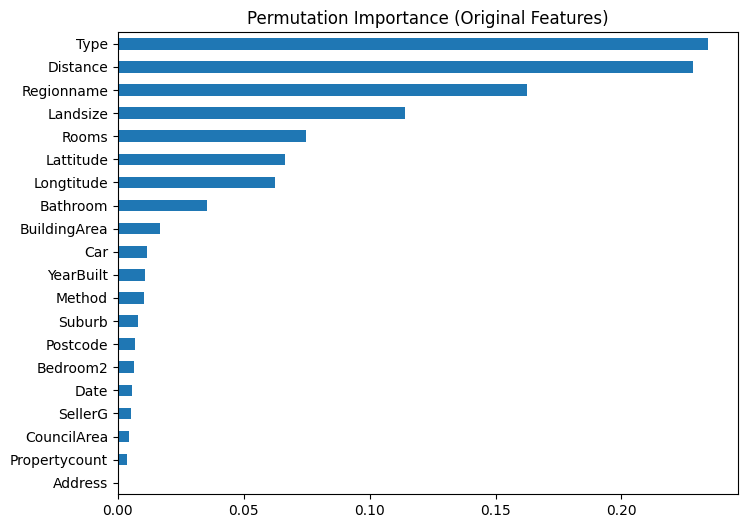

In [24]:
perm.head(20).sort_values().plot(kind="barh", figsize=(8,6), title="Permutation Importance (Original Features)")

---

## ✅ Conclusions

In this notebook, we built an end-to-end regression model for housing price prediction:

- Implemented a **scikit-learn Pipeline** combining preprocessing and modeling
- Handled missing values and categorical variables systematically
- Trained a **HistGradientBoostingRegressor** for strong tabular performance
- Improved stability using a **log-transform** of the target
- Evaluated predictions with **MAE** on a held-out validation set
- Interpreted results using **permutation importance**

This workflow mirrors what is commonly used in real-world applied ML projects.

## 🔜 Next Steps

Possible extensions include:

1. **Cross-validated hyperparameter tuning** (GridSearchCV / RandomizedSearchCV)
2. **Residual analysis** to understand systematic errors
3. **Feature engineering**, e.g., interactions or geographic clustering
4. **Model comparison** with linear models, random forests, or external GBMs
5. **Model persistence and inference** using `joblib`

These steps would naturally form the next iteration in an applied ML study or course module.